# Основная информация проекта

## Описание датасета

1. **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
2. **City** — город, в котором находится ресторан;
3. **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
4. **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
5. **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
6. **Price Range** — диапазон цен в ресторане;
7. **Number of Reviews** — количество отзывов о ресторане;
8. **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
9. **URL_TA** — URL страницы ресторана на TripAdvisor;
10. **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.

**Целевая переменная** - "Rating"

# Импорт библиотек и загрузка данных

In [1226]:
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from sklearn.model_selection import train_test_split

In [1099]:
RANDOM_SEED = 42

In [1100]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [1372]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Функции для обработки и анализа данных

In [1102]:
def find_null(col):
    '''Функция подсчёта количества пустых значений в столбцах датасета'''
    empty_values = data[col].isna().sum()
    print(
        f"В столбце '{col}' количество пропусков = {empty_values}.")
    return empty_values

In [1067]:
def last_date(x):
    '''Функция для определния последнего дня отзыва'''
    if len(x) > 0:
        return x[0]
    else:
        return 0

In [1068]:
def row_to_datetime(row):
    '''Функция для преобразования данных в списке в формат даты'''
    new_row = []
    if len(row) > 0:
        for i in row:
            new_row.append(pd.to_datetime(i, errors='coerce'))
        return new_row
    else:
        return []

In [1069]:
def delta_datetime(row):
    '''Функция подсчёта разницы между датами'''
    if len(row) == 2:
        return (row[0]-row[1]).days
    else:
        return 0

In [1079]:
def parsing_all_columns_data(data):
    '''Функция для анализа всех столбцов на количество 
    уникальных значений и количество пропусков'''

    for col in data.columns:
        unique_values = len(data[col].value_counts())
        empty_values = data[col].isna().sum()
        print(
            f"В столбце '{col}' уникальных значений = {unique_values} ,а количество пропусков = {empty_values}.")
        print(
            f'Процент пропусков = {round(empty_values*100/df.shape[0],1)}%')

In [1417]:
def preproc_data(df_input):
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['restaurant_id','id_ta',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['number_of_reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    #df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

# Обзор данных

In [1107]:
display(df_train.head(5))
df_train.info()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [1108]:
display(df_test.head(5))
df_test.info()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [1109]:
display(sample_submission.head(5))
sample_submission.info()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [1395]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [1384]:
display(data.head(5))
data.info()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [1385]:
# Вывод количества строк и столбцов таблицы
print(
    f'Датасет состоит из {data.shape[0]} строк и {data.shape[1]} столбцов')

Датасет состоит из 50000 строк и 11 столбцов


In [1397]:
# Приведём наименования колонок в общий вид
data.columns = map(str.lower, data.columns.str.replace(' ','_',regex=True))

# Работа с данными

## 1. Обработка NAN

In [1398]:
data['number_of_reviews_isnan'] = pd.isna(data['number_of_reviews']).astype('uint8')

In [1399]:
data['number_of_reviews_isnan']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: number_of_reviews_isnan, Length: 50000, dtype: uint8

In [1389]:
# Заполним пропуски средним значением по городу и кухне

In [1400]:
display(data['price_range'].unique())
display(data['price_range'].value_counts())

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [1401]:
data['number_of_price_range_isnan'] = pd.isna(data['price_range']).astype('uint8')

In [1404]:
data['number_of_price_range_isnan']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    1
49998    0
49999    0
Name: number_of_price_range_isnan, Length: 50000, dtype: uint8

Исходя из количества уникальных значений, можно сделать вывод, что самый распространенный диапозон цен = от 2-3. Заполним пропуски этим значением

In [1402]:
data['price_range'].fillna('$$ - $$$', inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [1403]:
parsing_all_columns_data(data)

В столбце 'restaurant_id' уникальных значений = 13094 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'city' уникальных значений = 31 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'cuisine_style' уникальных значений = 10731 ,а количество пропусков = 11590.
Процент пропусков = 29.0%
В столбце 'ranking' уникальных значений = 12975 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'price_range' уникальных значений = 3 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'number_of_reviews' уникальных значений = 1573 ,а количество пропусков = 3200.
Процент пропусков = 8.0%
В столбце 'reviews' уникальных значений = 41857 ,а количество пропусков = 2.
Процент пропусков = 0.0%
В столбце 'url_ta' уникальных значений = 49963 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'id_ta' уникальных значений = 49963 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'sample' уникальных значений = 2 ,а количество пропу

In [1405]:
#data = pd.get_dummies(data, columns=['city',], dummy_na=True)

In [1342]:
data.head(5)

,restaurant_id,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,...,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [1345]:
dict_value_price = {'$':1,'$$ - $$$':2,'$$$$':3}
data['price_range'] = data['price_range'].map(lambda x: dict_value_price.get(x,x))

А не проще создать признак, в котором просто подсчитывается количество кухонь в ресторане?
Типа
df[‘num_cuisine’] = df.Cuisine_Style.apply(len)
Конечно, чтобы это сработало, столбец Cuisine_Style должен содержать список кухонь.

# EDA 

### Посмотрим распределение признака

<AxesSubplot:>

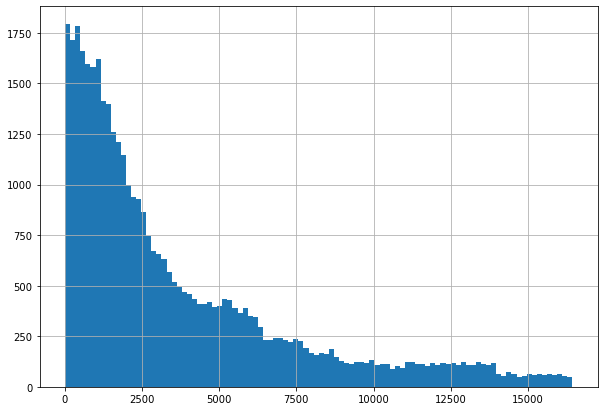

In [1346]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

<AxesSubplot:>

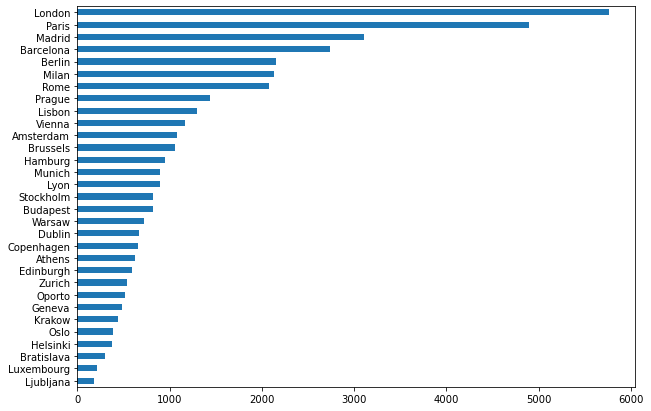

In [1347]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

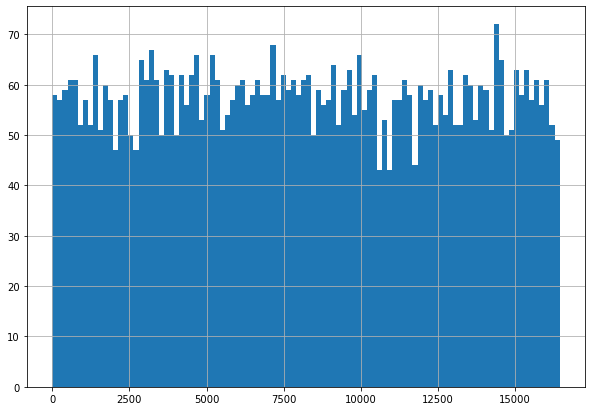

In [1348]:
df_train['Ranking'][df_train['City']=='London'].hist(bins=100)

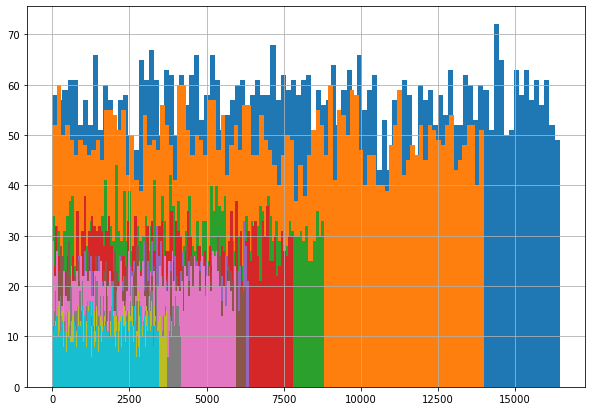

In [1349]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City']==x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

<AxesSubplot:>

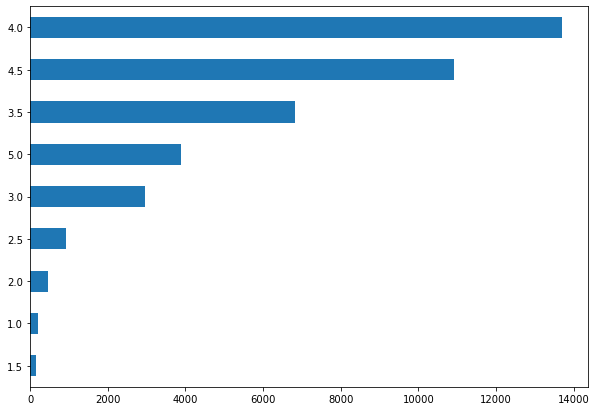

In [1350]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

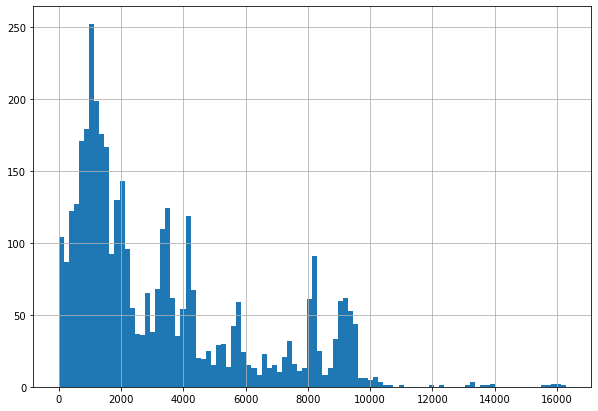

In [1351]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

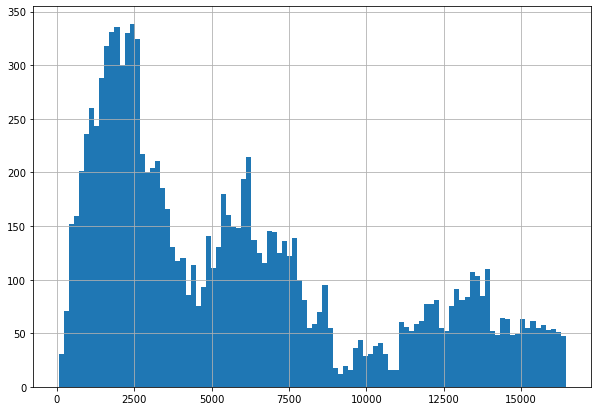

In [1243]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

<AxesSubplot:>

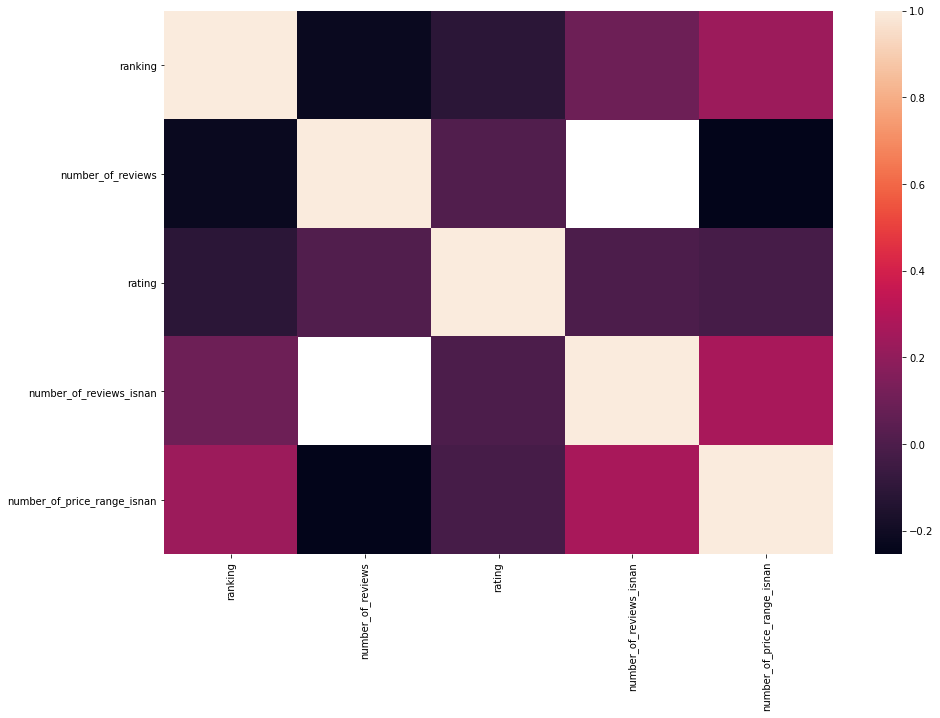

In [1406]:
plt.figure(figsize=(15,10))
sns.heatmap(data.drop(['sample'],axis=1).corr(),)

# Data Preprocessing

In [1407]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,ranking,number_of_reviews,sample,rating,number_of_reviews_isnan,number_of_price_range_isnan
30548,1103.0,0.0,1,5.0,1,0
27728,5365.0,5.0,1,4.0,0,1
10498,57.0,3491.0,1,4.5,0,0
44775,4480.0,17.0,1,5.0,0,0
13422,7606.0,5.0,1,2.0,0,1
13899,3891.0,11.0,1,4.5,0,1
40661,2580.0,924.0,1,3.5,0,0
39323,1209.0,265.0,1,4.0,0,0
9005,1934.0,60.0,0,0.0,0,0
5888,1625.0,22.0,0,0.0,0,0


In [1408]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

In [1409]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [1410]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 5), (40000, 5), (40000, 4), (32000, 4), (8000, 4))

# Model 
Сам ML

In [1411]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [1412]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [1413]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1414]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.4190509378382034


In [1415]:
y_pred

array([4.52833333, 4.015     , 3.92      , ..., 4.075     , 3.735     ,
       3.885     ])

<AxesSubplot:>

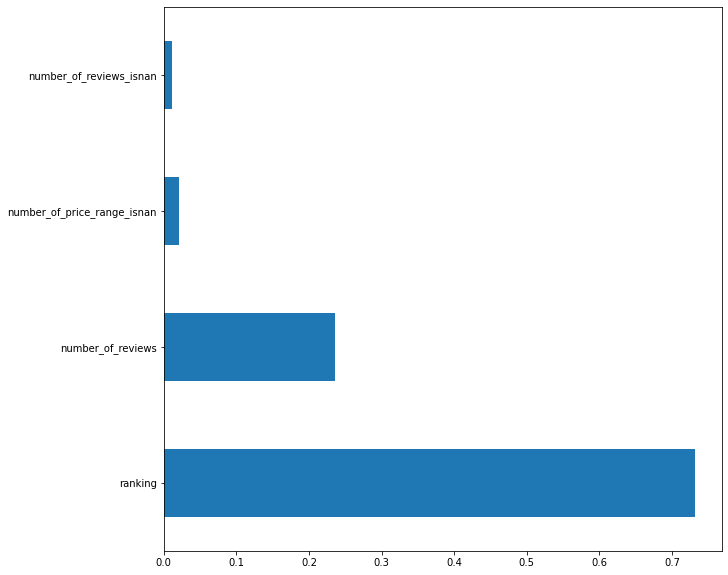

In [1416]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [1363]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,rating,number_of_reviews_isnan,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,...,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
4489,376.0,2,41.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
953,2341.0,2,2.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7751,4036.0,2,2.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6646,842.0,2,10.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5181,4996.0,1,18.0,0.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9853,12789.0,2,4.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3445,4819.0,2,8.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
84,251.0,2,95.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
528,6728.0,2,55.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8749,2003.0,2,7.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [1365]:
test_data = test_data.drop(['rating'], axis=1)

In [1371]:
sample_submission

,Restaurant_id,Rating,rating
0,id_0,3.005,3.005
1,id_1,4.305,4.305
2,id_2,4.530,4.530
3,id_3,4.200,4.200
4,id_4,4.485,4.485
...,...,...,...
9995,id_9995,4.505,4.505
9996,id_9996,4.070,4.070
9997,id_9997,3.010,3.010
9998,id_9998,4.500,4.500


In [1367]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1368]:
predict_submission

array([3.005, 4.305, 4.53 , ..., 3.01 , 4.5  , 4.325])

In [1370]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating,rating
0,id_0,3.005,3.005
1,id_1,4.305,4.305
2,id_2,4.530,4.530
3,id_3,4.200,4.200
4,id_4,4.485,4.485
5,id_5,4.635,4.635
6,id_6,1.770,1.770
7,id_7,3.375,3.375
8,id_8,4.110,4.110
9,id_9,4.780,4.780


# Вопросы

In [41]:
data['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [62]:
len(data['City'].value_counts())

31

In [1088]:
len(data['Cuisine Style'][0])

39

In [1095]:
df

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414
39996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036
39997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615
39998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838


# 4.3 Вопросы о кухнях

In [1062]:
test = data.copy()

In [1064]:
test.columns = map(str.lower, test.columns.str.replace(' ','_',regex=True))

In [947]:
test.columns = test.columns.str.replace(' ','_',regex=True)

In [948]:
#data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x : re.findall(r'\w+',x) if not pd.isna(x) else ['Unknown'])

In [949]:
test['cuisine_style'] = test['cuisine_style'].apply(lambda x : re.sub(r"[]['']",'',x) if not pd.isna(x) else 'Unknown')

In [1065]:
test.head(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [1085]:
test.query('number_of_reviews < 10')

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765
10,id_6578,Barcelona,NaN,6579.0,3.0,NaN,6.0,"[[], []]",/Restaurant_Review-g187497-d10696479-Reviews-R...,d10696479
14,id_4773,Madrid,"['Mediterranean', 'Spanish', 'Healthy']",4776.0,4.0,$$ - $$$,7.0,"[[], []]",/Restaurant_Review-g187514-d10859423-Reviews-B...,d10859423
...,...,...,...,...,...,...,...,...,...,...
39975,id_2323,Lisbon,NaN,2326.0,4.5,NaN,3.0,"[[], []]",/Restaurant_Review-g189158-d6988056-Reviews-Re...,d6988056
39983,id_2487,Amsterdam,NaN,2494.0,4.5,NaN,2.0,"[['Italian food, as in Italy!'], ['05/24/2015']]",/Restaurant_Review-g188590-d8120959-Reviews-Sa...,d8120959
39991,id_6655,Paris,"['French', 'Contemporary', 'Fusion', 'Gastropub']",6656.0,5.0,$$ - $$$,5.0,"[[], []]",/Restaurant_Review-g187147-d13224611-Reviews-L...,d13224611
39994,id_7074,Paris,"['French', 'Fast Food', 'Mediterranean', 'Heal...",7075.0,4.5,$$ - $$$,6.0,"[[], []]",/Restaurant_Review-g187147-d12621988-Reviews-C...,d12621988


## Сколько типов кухонь представлено в наборе данных?

In [951]:
t = Counter(test['cuisine_style'].str.split(', ').sum())

In [952]:
len(t) - 1

125

## Какая кухня представлена в наибольшем количестве ресторанов?

In [953]:
t.most_common(1)

[('Vegetarian Friendly', 11189)]

In [954]:
# data.head(8)

## Какое среднее количество кухонь предлагается в одном ресторане?

In [955]:
test['cuisine_style'] = test['cuisine_style'].str.split(', ')

In [956]:
test.head(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,[Unknown],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


In [957]:
summ = 0
for i in test['cuisine_style']:
    summ += len(i)

In [958]:
summ/test.shape[0]

2.6224

# 4.4 Вопросы об отзывах

In [959]:
test['reviews'][0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [400]:
#test['Reviews'] = test['Reviews'].apply(lambda x : re.sub(r"[]['']",'',x) if not pd.isna(x) else 'Unknown')

In [530]:
# test['Reviews'].apply(lambda x : re.sub(r"['][']",'',x))

In [486]:
#pattern = re.compile('\d+\/\d+\/\d+')
#test['Reviews_date'] = test['Reviews'].apply(lambda x: pattern.findall(x))

In [471]:
#d = test['Reviews'].str.replace('[]['']','').str.split(', ')

In [487]:
#d[0][:2:]

In [678]:
#test['reviews'] = test['reviews'].apply(lambda x : re.sub(r"[]['']",'',x)).str.split(', ')

In [679]:
#print(dd[39995][:2:])
#print(dd[39995][2::])

['The real Italian experience!', 'Wonderful food']
['wonderful experience', '12/16/2017', '11/12/2017']


In [680]:
def test2(row):    
    return row[-int(len(row)/2)::]

In [681]:
def test3(row):
    return row[:int(len(row)/2):]

In [553]:
#test['reviews'].apply(test2)

0                              [12/31/2017, 11/20/2017]
1                              [07/06/2017, 06/19/2016]
2                              [01/08/2018, 01/06/2018]
3                                                    []
4                              [11/18/2017, 02/19/2017]
                              ...                      
39995    [wonderful experience, 12/16/2017, 11/12/2017]
39996                          [12/21/2017, 12/12/2017]
39997                          [11/03/2016, 04/12/2008]
39998                          [07/11/2017, 06/18/2017]
39999                          [01/31/2016, 07/04/2012]
Name: Reviews, Length: 40000, dtype: object

In [560]:
#test['reviews'].apply(test3)

0        [Good food at your doorstep, A good hotel rest...
1                [Unique cuisine, Delicious Nepalese food]
2                 [Catch up with friends, Not exceptional]
3                                                       []
4        [Best place to try a Bavarian food, Nice build...
                               ...                        
39995       [The real Italian experience!, Wonderful food]
39996    [Parisian atmosphere, Bit pricey but interesti...
39997    [Good by swedish standards, A hidden jewel in ...
39998    [Underground restaurant, Oldest Restaurant in ...
39999                          [Average, Nice an informal]
Name: Reviews, Length: 40000, dtype: object

In [960]:
pattern = re.compile('\d+\/\d+\/\d+')
test['reviews_date'] = test['reviews'].apply(lambda x: pattern.findall(x))

In [961]:
#pd.to_datetime(test['reviews_date']).dt.date

In [962]:
def last_date(x):
    if len(x) > 0:
        return x[0]
    else:
        return 0

In [963]:
test['last_reviews_date'] = test['reviews_date'].apply(last_date)

In [964]:
test['last_reviews_date'] = pd.to_datetime(test['last_reviews_date'],errors='coerce')

In [965]:
test['last_reviews_date'] = test['last_reviews_date'].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))

In [966]:
test.last_reviews_date.sort_values(ascending=False)

5635     2018-02-26
29251    2018-02-26
8135     2018-02-26
25943    2018-02-26
30334    2018-02-26
            ...    
21482    1970-01-01
5671     1970-01-01
21481    1970-01-01
21480    1970-01-01
4705     1970-01-01
Name: last_reviews_date, Length: 40000, dtype: object

In [832]:
'''
def dates_dif(row):
    if row is None:
        return None
    elif len(row) == 2:
        first = row[0]
        second = row[1]
        if first > second:
            dif = first - second
        else:
            dif = second - first
        dif = str(dif)
        dif = dif[:dif.find('day')]
        dif = int(dif)
        return dif
    else:
        return None
test['Difference between Dates'] = test['reviews_date'].apply(dates_dif)
'''

"\ndef dates_dif(row):\n    if row is None:\n        return None\n    elif len(row) == 2:\n        first = row[0]\n        second = row[1]\n        if first > second:\n            dif = first - second\n        else:\n            dif = second - first\n        dif = str(dif)\n        dif = dif[:dif.find('day')]\n        dif = int(dif)\n        return dif\n    else:\n        return None\ntest['Difference between Dates'] = test['reviews_date'].apply(dates_dif)\n"

In [967]:
type(test['reviews_date'][0][0])

str

In [1026]:
def t(row):
    new_row = []
    if len(row)>0:
        for i in row:
            new_row.append(pd.to_datetime(i,errors='coerce'))
        return new_row
    else:
        return []

In [1027]:
tt = test.copy()

In [1028]:
tt['reviews_date'] = tt['reviews_date'].apply(t)

In [997]:
type(tt['reviews_date'][0][0])

str

In [1087]:
tt['restaurant_id'].value_counts()

id_436      18
id_871      18
id_227      18
id_633      18
id_430      17
            ..
id_10197     1
id_10886     1
id_12426     1
id_14430     1
id_15967     1
Name: restaurant_id, Length: 11909, dtype: int64

In [1044]:
for row in tt['reviews_date']:
    if len(row)==2:
        print((row[0]-row[1]).days)
    elif len(row) == 1:
        print(row)

41
382
2
272
108
-93
613
225
23
11
56
78
[Timestamp('2017-04-12 00:00:00')]
120
299
243
8
98
57
89
[Timestamp('2016-07-05 00:00:00')]
[Timestamp('2017-01-26 00:00:00')]
[Timestamp('2011-08-20 00:00:00')]
27
241
[Timestamp('2015-10-26 00:00:00')]
194
489
[Timestamp('2015-03-08 00:00:00')]
[Timestamp('2017-05-12 00:00:00')]
81
100
-299
164
1
-180
32
25
82
51
0
[Timestamp('2016-03-19 00:00:00')]
[Timestamp('2014-11-10 00:00:00')]
[Timestamp('2012-04-13 00:00:00')]
66
88
106
0
4
357
51
11
193
698
[Timestamp('2014-12-09 00:00:00')]
1
256
35
12
99
[Timestamp('2016-09-04 00:00:00')]
5
75
373
1
140
52
423
65
445
9
56
[Timestamp('2016-10-14 00:00:00')]
94
79
136
100
17
124
145
248
189
129
84
33
664
22
445
288
3
1086
112
120
80
21
18
98
308
0
41
40
48
8
204
25
[Timestamp('2014-08-04 00:00:00')]
43
147
169
739
3
139
128
-225
257
8
46
121
0
18
70
6
188
[Timestamp('2017-12-07 00:00:00')]
[Timestamp('2018-02-09 00:00:00')]
9
36
32
49
46
8
0
11
294
63
59
235
48
[Timestamp('2013-03-16 00:00:00')]
-214

132
[Timestamp('2016-11-03 00:00:00')]
91
285
0
1
86
-149
63
60
514
26
2
271
-72
8
1
[Timestamp('2016-07-09 00:00:00')]
[Timestamp('2017-04-11 00:00:00')]
145
1
91
144
-99
24
82
210
1355
46
40
17
30
72
58
538
7
114
144
173
62
[Timestamp('2017-07-14 00:00:00')]
6
25
30
[Timestamp('2016-08-28 00:00:00')]
114
196
145
[Timestamp('2015-06-24 00:00:00')]
12
375
40
110
207
773
3
[Timestamp('2016-12-15 00:00:00')]
12
[Timestamp('2017-10-21 00:00:00')]
[Timestamp('2017-01-05 00:00:00')]
48
101
430
4
33
205
594
62
-223
54
-116
680
8
99
7
4
83
21
11
39
558
32
19
1074
[Timestamp('2016-08-20 00:00:00')]
[Timestamp('2016-04-26 00:00:00')]
1
59
349
6
25
17
0
22
27
101
18
[Timestamp('2017-08-23 00:00:00')]
263
136
-55
25
183
31
26
141
2
225
101
1
26
38
37
16
529
10
36
183
28
61
279
217
166
35
92
46
14
[Timestamp('2015-09-17 00:00:00')]
42
339
[Timestamp('2012-03-21 00:00:00')]
[Timestamp('2016-07-17 00:00:00')]
37
113
4
91
[Timestamp('2016-09-05 00:00:00')]
0
7
63
436
[Timestamp('2014-06-20 00:00:00')

-282
7
17
379
153
190
[Timestamp('2018-01-06 00:00:00')]
104
[Timestamp('2017-08-06 00:00:00')]
[Timestamp('2017-07-16 00:00:00')]
43
-215
635
[Timestamp('2017-12-04 00:00:00')]
[Timestamp('2017-01-13 00:00:00')]
12
6
78
43
-285
166
[Timestamp('2017-01-21 00:00:00')]
290
115
49
33
-120
-241
128
7
128
45
468
87
101
3
63
77
134
200
1
64
105
26
96
3
30
1818
[Timestamp('2014-10-13 00:00:00')]
91
21
309
144
80
32
34
443
29
[Timestamp('2013-10-11 00:00:00')]
-200
[Timestamp('2016-01-15 00:00:00')]
143
[Timestamp('2013-09-03 00:00:00')]
26
55
26
95
[Timestamp('2017-04-10 00:00:00')]
-325
114
296
82
361
398
167
300
60
6
88
5
2
141
724
179
10
30
76
23
20
[Timestamp('2017-06-21 00:00:00')]
35
[Timestamp('2015-11-30 00:00:00')]
27
1
133
124
38
229
24
216
993
78
[Timestamp('2016-03-03 00:00:00')]
64
46
[Timestamp('2014-09-11 00:00:00')]
28
40
[Timestamp('2016-12-01 00:00:00')]
143
3
133
2
33
4
44
21
105
10
2
12
11
[Timestamp('2017-09-26 00:00:00')]
[Timestamp('2015-11-09 00:00:00')]
[Timestamp('20

169
17
[Timestamp('2017-08-28 00:00:00')]
[Timestamp('2015-12-24 00:00:00')]
72
-1
110
[Timestamp('2015-04-28 00:00:00')]
65
8
700
104
149
170
[Timestamp('2015-09-23 00:00:00')]
33
33
97
-259
1
[Timestamp('2016-10-03 00:00:00')]
108
3
688
[Timestamp('2016-07-03 00:00:00')]
135
10
241
39
164
708
85
293
81
14
108
172
26
195
188
[Timestamp('2017-11-24 00:00:00')]
83
-136
28
8
3
[Timestamp('2017-06-01 00:00:00')]
229
243
[Timestamp('2017-11-03 00:00:00')]
[Timestamp('2017-11-20 00:00:00')]
20
-115
3
1
8
162
99
547
[Timestamp('2015-09-25 00:00:00')]
28
2
128
687
789
[Timestamp('2017-11-21 00:00:00')]
269
44
49
[Timestamp('2017-03-06 00:00:00')]
69
155
51
539
271
777
0
33
153
[Timestamp('2017-07-16 00:00:00')]
0
113
134
-145
308
148
97
1490
527
1093
27
128
47
-31
921
27
174
[Timestamp('2016-09-24 00:00:00')]
630
88
37
167
22
279
-13
34
140
[Timestamp('2016-04-20 00:00:00')]
[Timestamp('2011-11-23 00:00:00')]
76
[Timestamp('2016-07-16 00:00:00')]
220
312
75
222
50
159
[Timestamp('2014-06-29 0

2
18
341
40
10
37
1
69
160
179
1
19
76
4
30
24
[Timestamp('2016-08-06 00:00:00')]
14
-200
43
85
2
[Timestamp('2017-02-12 00:00:00')]
60
16
90
[Timestamp('2014-06-13 00:00:00')]
108
[Timestamp('2016-05-11 00:00:00')]
[Timestamp('2015-07-07 00:00:00')]
16
52
151
135
34
[Timestamp('2017-12-02 00:00:00')]
232
103
0
162
37
209
103
109
163
62
121
-103
[Timestamp('2017-04-25 00:00:00')]
49
244
623
82
34
278
92
[Timestamp('2016-06-11 00:00:00')]
38
123
167
86
28
4
70
101
18
71
86
56
8
53
25
81
708
262
279
[Timestamp('2014-06-02 00:00:00')]
[Timestamp('2015-06-02 00:00:00')]
[Timestamp('2017-09-11 00:00:00')]
90
14
573
0
42
90
10
1
12
26
11
58
[Timestamp('2017-05-12 00:00:00')]
19
30
261
14
5
1
41
9
536
[Timestamp('2017-03-13 00:00:00')]
526
[Timestamp('2015-03-05 00:00:00')]
5
79
17
23
-60
25
20
257
23
5
12
153
66
461
68
193
111
26
25
[Timestamp('2017-05-31 00:00:00')]
604
80
105
[Timestamp('2017-07-20 00:00:00')]
8
14
[Timestamp('2016-08-18 00:00:00')]
489
86
36
1467
87
88
2
134
18
235
15
35


62
[Timestamp('2016-11-15 00:00:00')]
199
2
[Timestamp('2017-11-04 00:00:00')]
27
12
48
215
38
153
20
9
364
5
19
157
439
245
127
[Timestamp('2016-12-31 00:00:00')]
23
[Timestamp('2017-08-01 00:00:00')]
18
5
33
-18
1218
13
1
388
91
-88
48
16
243
301
532
25
109
329
-17
[Timestamp('2017-03-30 00:00:00')]
[Timestamp('2017-10-21 00:00:00')]
[Timestamp('2013-09-09 00:00:00')]
88
-129
409
6
196
173
94
[Timestamp('2017-10-22 00:00:00')]
-189
54
1
9
210
31
3
410
23
-243
6
25
67
175
[Timestamp('2016-02-15 00:00:00')]
188
64
[Timestamp('2017-08-28 00:00:00')]
103
39
40
530
-35
26
136
180
437
12
[Timestamp('2016-08-11 00:00:00')]
245
27
-3
-286
-273
65
51
67
111
68
-145
711
1
5
217
300
36
197
708
10
[Timestamp('2017-05-18 00:00:00')]
2
-34
128
4
0
774
41
207
134
71
57
-101
117
[Timestamp('2016-05-20 00:00:00')]
13
5
284
[Timestamp('2016-08-27 00:00:00')]
457
-245
24
147
0
8
78
-99
28
332
[Timestamp('2017-09-11 00:00:00')]
21
6
[Timestamp('2017-04-25 00:00:00')]
-40
169
[Timestamp('2017-07-11 00:00

66
40
3
100
-122
95
364
58
52
-298
0
100
-252
0
59
4
7
12
183
516
28
10
184
[Timestamp('2014-11-01 00:00:00')]
21
486
68
1
51
[Timestamp('2018-01-02 00:00:00')]
182
7
13
[Timestamp('2017-09-08 00:00:00')]
55
10
234
[Timestamp('2016-02-10 00:00:00')]
87
26
63
3
28
342
-36
74
180
14
41
93
-89
601
[Timestamp('2017-09-30 00:00:00')]
249
214
146
540
[Timestamp('2015-09-02 00:00:00')]
[Timestamp('2016-07-31 00:00:00')]
3
184
6
181
128
14
12
3
55
146
[Timestamp('2017-04-18 00:00:00')]
346
28
3
199
1326
3
[Timestamp('2017-12-29 00:00:00')]
80
-94
1
[Timestamp('2017-03-14 00:00:00')]
62
[Timestamp('2017-07-16 00:00:00')]
3
0
[Timestamp('2017-12-05 00:00:00')]
55
207
562
-97
15
301
85
36
30
194
19
218
112
3
19
-217
[Timestamp('2017-08-13 00:00:00')]
54
-28
187
1314
225
53
82
1
37
111
6
16
4
30
24
31
[Timestamp('2017-10-04 00:00:00')]
62
121
49
26
12
4
3
81
5
7
143
97
8
6
[Timestamp('2017-07-19 00:00:00')]
42
78
74
156
[Timestamp('2016-06-26 00:00:00')]
40
91
-63
[Timestamp('2015-06-19 00:00:00')

790
40
400
[Timestamp('2016-09-27 00:00:00')]
2
-61
[Timestamp('2017-10-30 00:00:00')]
57
351
[Timestamp('2016-07-13 00:00:00')]
54
71
[Timestamp('2017-10-05 00:00:00')]
42
5
24
143
675
14
10
322
57
-281
[Timestamp('2017-07-22 00:00:00')]
55
674
27
12
52
[Timestamp('2013-11-23 00:00:00')]
24
30
78
45
121
46
68
103
104
[Timestamp('2017-03-30 00:00:00')]
222
-108
62
11
71
[Timestamp('2018-01-02 00:00:00')]
299
114
0
590
42
68
[Timestamp('2015-03-07 00:00:00')]
[Timestamp('2016-07-08 00:00:00')]
230
1192
657
416
100
73
205
13
219
36
49
4
[Timestamp('2017-06-09 00:00:00')]
[Timestamp('2017-11-23 00:00:00')]
186
220
163
[Timestamp('2014-01-14 00:00:00')]
320
11
24
71
9
7
2
133
43
191
681
305
2
62
280
271
92
218
260
0
-4
148
45
42
24
27
598
106
75
[Timestamp('2017-12-02 00:00:00')]
24
103
[Timestamp('2014-11-26 00:00:00')]
29
8
1
[Timestamp('2017-02-06 00:00:00')]
33
-93
8
38
346
40
[Timestamp('2016-07-08 00:00:00')]
8
3
142
30
6
182
91
-102
174
208
99
197
-335
84
786
-185
56
132
2
454
141
8

6
44
108
[Timestamp('2016-12-16 00:00:00')]
147
[Timestamp('2012-10-30 00:00:00')]
10
234
[Timestamp('2017-12-25 00:00:00')]
31
24
4
59
52
11
23
240
23
83
107
44
486
5
97
941
41
-44
[Timestamp('2016-02-06 00:00:00')]
59
215
315
31
74
171
[Timestamp('2017-05-05 00:00:00')]
21
[Timestamp('2017-12-06 00:00:00')]
376
51
21
26
[Timestamp('2014-06-10 00:00:00')]
11
933
63
22
[Timestamp('2017-11-26 00:00:00')]
658
44
70
[Timestamp('2017-10-22 00:00:00')]
94
210
[Timestamp('2017-12-01 00:00:00')]
[Timestamp('2014-09-27 00:00:00')]
680
10
64
-3
161
186
20
30
94
20
80
201
259
8
9
110
258
[Timestamp('2009-05-18 00:00:00')]
-33
-257
23
284
35
[Timestamp('2017-05-24 00:00:00')]
64
222
90
75
340
62
27
52
[Timestamp('2017-11-01 00:00:00')]
-32
32
18
1
67
4
306
462
54
-56
[Timestamp('2015-11-10 00:00:00')]
87
97
76
137
29
90
22
[Timestamp('2015-03-09 00:00:00')]
[Timestamp('2017-05-21 00:00:00')]
-91
4
79
[Timestamp('2014-10-28 00:00:00')]
[Timestamp('2014-03-20 00:00:00')]
211
266
28
14
189
56
137
16

24
8
3
23
46
58
417
225
44
221
48
[Timestamp('2015-05-24 00:00:00')]
82
81
6
19
107
1
204
36
15
[Timestamp('2018-01-19 00:00:00')]
184
13
15
24
[Timestamp('2017-01-10 00:00:00')]
278
16
16
[Timestamp('2017-09-01 00:00:00')]
13
338
203
111
443
26
2
9
18
3
[Timestamp('2017-10-12 00:00:00')]
[Timestamp('2017-04-23 00:00:00')]
9
[Timestamp('2017-10-14 00:00:00')]
1
[Timestamp('2017-03-10 00:00:00')]
15
279
43
509
305
[Timestamp('2017-10-03 00:00:00')]
4
44
285
111
28
-42
98
36
82
31
476
336
21
24
-93
1798
4
58
177
10
32
165
[Timestamp('2015-08-30 00:00:00')]
331
88
182
[Timestamp('2016-10-06 00:00:00')]
23
170
203
[Timestamp('2015-07-31 00:00:00')]
32
10
315
11
58
-149
1
[Timestamp('2017-12-31 00:00:00')]
2
37
1
[Timestamp('2016-09-01 00:00:00')]
5
20
-192
[Timestamp('2016-10-24 00:00:00')]
68
68
[Timestamp('2017-04-05 00:00:00')]
100
378
241
4
73
319
138
184
-165
[Timestamp('2015-04-27 00:00:00')]
116
16
90
488
1
244
222
[Timestamp('2017-03-27 00:00:00')]
351
119
344
4
474
28
[Timestamp('

[Timestamp('2017-04-13 00:00:00')]
14
5
100
13
136
20
-9
2
-58
136
[Timestamp('2017-04-23 00:00:00')]
26
9
[Timestamp('2016-01-13 00:00:00')]
-217
18
[Timestamp('2015-04-04 00:00:00')]
84
18
124
108
[Timestamp('2017-04-18 00:00:00')]
3
70
14
21
-91
93
99
92
1
20
316
66
[Timestamp('2017-02-22 00:00:00')]
30
17
15
325
35
90
363
[Timestamp('2016-06-05 00:00:00')]
[Timestamp('2017-09-03 00:00:00')]
[Timestamp('2016-10-13 00:00:00')]
77
13
50
903
309
580
101
[Timestamp('2015-08-30 00:00:00')]
343
233
566
-273
532
72
28
26
-127
9
27
25
17
71
91
80
-184
66
78
[Timestamp('2014-06-26 00:00:00')]
31
203
315
91
-65
1380
27
443
58
151
[Timestamp('2016-10-26 00:00:00')]
13
[Timestamp('2016-08-10 00:00:00')]
39
3
142
409
487
47
[Timestamp('2015-03-31 00:00:00')]
340
21
255
218
3
273
[Timestamp('2017-03-03 00:00:00')]
[Timestamp('2014-12-22 00:00:00')]
245
11
49
38
-26
309
24
37
222
4
6
109
[Timestamp('2013-03-03 00:00:00')]
664
227
1
7
[Timestamp('2017-02-19 00:00:00')]
388
20
1
12
[Timestamp('2015-

2
10
95
167
69
124
874
-72
23
137
50
125
18
[Timestamp('2017-02-14 00:00:00')]
1
211
116
8
363
-115
7
188
26
60
189
13
16
3
19
99
173
133
588
5
[Timestamp('2017-12-17 00:00:00')]
-299
19
619
0
4
89
93
1
15
22
275
233
188
[Timestamp('2017-10-01 00:00:00')]
39
309
721
302
1
5
[Timestamp('2016-10-31 00:00:00')]
25
76
47
9
331
21
11
[Timestamp('2018-01-31 00:00:00')]
[Timestamp('2017-07-19 00:00:00')]
148
63
[Timestamp('2015-04-23 00:00:00')]
[Timestamp('2016-07-09 00:00:00')]
74
945
-27
8
0
3
[Timestamp('2016-09-09 00:00:00')]
21
173
304
56
1297
76
16
13
26
26
82
[Timestamp('2016-04-28 00:00:00')]
75
35
32
3
99
0
39
36
5
11
56
-59
257
[Timestamp('2016-08-22 00:00:00')]
17
[Timestamp('2014-10-19 00:00:00')]
[Timestamp('2015-12-25 00:00:00')]
55
[Timestamp('2017-11-29 00:00:00')]
18
100
274
70
22
136
236
-157
233
169
[Timestamp('2015-09-26 00:00:00')]
38
7
155
125
76
232
5
16
221
9
158
20
[Timestamp('2017-09-20 00:00:00')]
217
[Timestamp('2017-08-01 00:00:00')]
84
2
[Timestamp('2014-09-20 0

32
[Timestamp('2016-10-31 00:00:00')]
458
1
233
17
191
136
41
3
129
22
32
219
7
3
14
29
180
25
16
45
3
42
35
[Timestamp('2017-10-10 00:00:00')]
-165
188
282
275
50
220
126
42
177
-197
1109
176
11
32
[Timestamp('2017-07-31 00:00:00')]
27
128
316
8
[Timestamp('2015-06-14 00:00:00')]
[Timestamp('2012-04-18 00:00:00')]
268
13
104
-5
362
226
-81
66
[Timestamp('2017-11-17 00:00:00')]
85
[Timestamp('2017-02-23 00:00:00')]
8
51
210
[Timestamp('2015-08-08 00:00:00')]
28
35
19
4
81
9
98
101
15
-91
24
41
-49
17
-107
5
53
299
-164
319
2
23
18
36
13
287
22
14
51
45
0
[Timestamp('2017-11-10 00:00:00')]
459
281
16
[Timestamp('2014-11-07 00:00:00')]
1
18
40
4
40
44
497
[Timestamp('2012-01-05 00:00:00')]
13
69
46
50
-98
42
37
[Timestamp('2017-11-06 00:00:00')]
[Timestamp('2016-03-27 00:00:00')]
25
0
106
11
57
51
243
-272
-331
512
362
151
[Timestamp('2017-07-29 00:00:00')]
802
215
1
112
11
48
-223
5
318
104
[Timestamp('2015-08-29 00:00:00')]
4
[Timestamp('2016-11-24 00:00:00')]
26
9
3
5
[Timestamp('2015

222
81
249
[Timestamp('2016-10-01 00:00:00')]
20
59
953
25
508
45
75
578
2
21
1
[Timestamp('2017-08-07 00:00:00')]
203
39
64
5
283
[Timestamp('2017-01-04 00:00:00')]
65
12
12
1346
1067
35
111
19
87
4
146
10
22
8
-30
-120
[Timestamp('2015-07-13 00:00:00')]
-237
604
116
64
116
266
[Timestamp('2008-03-07 00:00:00')]
1108
113
469
338
1
1
16
0
[Timestamp('2013-02-21 00:00:00')]
293
15
[Timestamp('2017-09-24 00:00:00')]
100
391
1
447
36
41
5
[Timestamp('2017-01-11 00:00:00')]
288
[Timestamp('2016-08-09 00:00:00')]
[Timestamp('2015-04-28 00:00:00')]
617
1228
2
98
34
56
6
-23
131
[Timestamp('2010-03-03 00:00:00')]
33
37
4
-159
117
3
41
0
[Timestamp('2016-01-15 00:00:00')]
59
26
0
[Timestamp('2017-04-17 00:00:00')]
56
17
5
356
54
324
41
27
36
[Timestamp('2017-04-03 00:00:00')]
86
[Timestamp('2014-12-17 00:00:00')]
22
[Timestamp('2014-02-12 00:00:00')]
1734
7
40
99
56
11
157
95
110
[Timestamp('2014-12-31 00:00:00')]
5
[Timestamp('2015-10-26 00:00:00')]
208
127
[Timestamp('2015-03-08 00:00:00')]


60
326
456
96
16
20
7
12
78
468
1
14
10
25
124
87
13
[Timestamp('2017-09-07 00:00:00')]
48
57
81
142
-196
[Timestamp('2017-08-22 00:00:00')]
64
39
19
158
34
933
18
[Timestamp('2017-04-30 00:00:00')]
19
73
178
29
30
144
210
69
72
10
56
166
30
290
8
19
39
52
230
68
61
166
1
29
-135
[Timestamp('2016-02-13 00:00:00')]
59
18
19
104
478
60
334
4
2
71
706
297
167
88
102
160
122
35
90
27
215
102
679
84
66
30
41
128
28
121
64
8
10
11
222
102
13
4
168
[Timestamp('2017-09-23 00:00:00')]
25
104
69
264
34
28
[Timestamp('2016-02-16 00:00:00')]
155
172
32
90
173
47
63
20
125
26
[Timestamp('2016-10-10 00:00:00')]
[Timestamp('2017-06-27 00:00:00')]
60
71
71
-157
82
17
1406
101
47
67
83
57
50
51
20
14
165
934
42
[Timestamp('2014-05-14 00:00:00')]
12
22
1030
[Timestamp('2017-06-15 00:00:00')]
297
115
21
6
84
29
13
445
295
76
1
[Timestamp('2017-04-23 00:00:00')]
244
59
[Timestamp('2016-10-22 00:00:00')]
18
15
[Timestamp('2015-02-10 00:00:00')]
9
[Timestamp('2017-05-15 00:00:00')]
53
1104
[Timestamp('2016-

19
70
1063
-76
67
43
58
1
206
46
140
72
5
[Timestamp('2017-10-11 00:00:00')]
-206
548
112
46
4
85
151
483
53
39
20
4
11
[Timestamp('2017-12-18 00:00:00')]
177
8
166
1314
147
36
262
-187
306
26
60
225
565
325
58
241
53
73
246
[Timestamp('2014-04-21 00:00:00')]
15
176
420
154
0
190
[Timestamp('2017-05-16 00:00:00')]
17
[Timestamp('2017-05-31 00:00:00')]
404
20
[Timestamp('2018-02-06 00:00:00')]
380
[Timestamp('2014-04-24 00:00:00')]
236
0
516
[Timestamp('2017-06-22 00:00:00')]
0
[Timestamp('2017-07-24 00:00:00')]
6
737
74
142
[Timestamp('2013-12-24 00:00:00')]
73
27
216
-250
32
[Timestamp('2017-06-06 00:00:00')]
7
96
3
54
115
25
78
[Timestamp('2012-01-05 00:00:00')]
117
14
33
21
-114
1
59
19
[Timestamp('2015-09-11 00:00:00')]
-144
99
10
[Timestamp('2014-08-15 00:00:00')]
68
113
118
68
267
587
7
292
109
165
28
34
[Timestamp('2013-01-15 00:00:00')]
99
55
[Timestamp('2017-07-12 00:00:00')]
193
2
11
15
4
67
234
67
8
139
35
65
90
704
5
78
85
27
6
377
229
277
161
99
322
48
311
[Timestamp('2015

5
373
145
73
218
84
41
267
145
65
88
294
24
69
93
675
1097
71
-196
10
184
459
33
47
[Timestamp('2015-10-09 00:00:00')]
297
162
18
3
57
629
11
-59
93
1457
21
301
2
153
[Timestamp('2018-01-13 00:00:00')]
4
318
-33
53
[Timestamp('2016-03-21 00:00:00')]
[Timestamp('2017-04-11 00:00:00')]
244
35
[Timestamp('2015-05-09 00:00:00')]
-70
31
63
36
[Timestamp('2011-11-23 00:00:00')]
[Timestamp('2016-08-31 00:00:00')]
116
196
15
76
11
310
[Timestamp('2014-11-21 00:00:00')]
47
105
10
77
855
-95
29
[Timestamp('2017-09-07 00:00:00')]
81
121
573
12
26
9
0
33
23
1
280
15
311
28
53
[Timestamp('2016-01-21 00:00:00')]
974
45
48
6
-187
23
114
-226
14
28
[Timestamp('2017-11-13 00:00:00')]
1534
47
54
1
209
[Timestamp('2016-08-04 00:00:00')]
600
37
-150
13
236
0
48
18
15
109
105
2
10
[Timestamp('2017-12-16 00:00:00')]
33
55
7
[Timestamp('2014-11-10 00:00:00')]
[Timestamp('2017-03-17 00:00:00')]
11
9
41
[Timestamp('2015-07-16 00:00:00')]
122
39
168
239
31
1
305
138
65
[Timestamp('2017-10-22 00:00:00')]
[Timest

14
22
170
[Timestamp('2016-09-09 00:00:00')]
54
374
[Timestamp('2017-04-06 00:00:00')]
[Timestamp('2016-06-27 00:00:00')]
252
393
101
130
1
12
11
566
5
[Timestamp('2017-07-25 00:00:00')]
180
124
367
55
161
12
47
78
[Timestamp('2014-09-03 00:00:00')]
10
2940
12
6
446
23
539
127
484
3
13
22
91
-110
91
328
224
16
676
31
100
254
26
36
25
143
278
1
1741
57
292
[Timestamp('2012-09-25 00:00:00')]
162
77
46
44
376
359
[Timestamp('2017-08-02 00:00:00')]
199
103
-51
93
[Timestamp('2017-06-24 00:00:00')]
[Timestamp('2017-09-09 00:00:00')]
35
12
[Timestamp('2015-05-15 00:00:00')]
[Timestamp('2014-07-29 00:00:00')]
62
139
19
46
227
139
58
42
[Timestamp('2017-02-10 00:00:00')]
[Timestamp('2014-09-12 00:00:00')]
45
40
2
26
110
5
[Timestamp('2015-01-31 00:00:00')]
239
228
2
217
1
34
89
1
-268
434
86
7
130
[Timestamp('2017-02-21 00:00:00')]
[Timestamp('2013-05-14 00:00:00')]
5
24
-64
7
51
42
40
79
[Timestamp('2017-10-08 00:00:00')]
2
1
2
[Timestamp('2015-09-17 00:00:00')]
4
990
31
10
-99
[Timestamp('20

[Timestamp('2016-11-01 00:00:00')]
512
[Timestamp('2016-02-10 00:00:00')]
2
433
292
[Timestamp('2017-08-22 00:00:00')]
34
30
276
414
35
320
13
[Timestamp('2015-12-15 00:00:00')]
[Timestamp('2016-11-01 00:00:00')]
-189
57
8
17
4
76
70
[Timestamp('2016-06-12 00:00:00')]
7
35
81
25
711
-50
64
1
102
88
[Timestamp('2014-08-18 00:00:00')]
20
19
164
17
247
46
[Timestamp('2017-06-01 00:00:00')]
13
69
[Timestamp('2016-06-23 00:00:00')]
133
331
45
58
214
430
6
95
135
136
1
0
[Timestamp('2015-06-28 00:00:00')]
76
-3
[Timestamp('2016-12-03 00:00:00')]
339
24
-110
61
2
9
396
[Timestamp('2014-01-31 00:00:00')]
20
148
1
3
73
46
303
352
64
[Timestamp('2016-10-31 00:00:00')]
176
16
121
33
90
654
[Timestamp('2016-10-15 00:00:00')]
[Timestamp('2017-03-28 00:00:00')]
8
96
328
18
[Timestamp('2017-04-09 00:00:00')]
138
239
37
381
31
147
2
153
[Timestamp('2016-11-17 00:00:00')]
170
8
8
372
2
[Timestamp('2017-08-28 00:00:00')]
1195
478
-159
446
21
82
188
[Timestamp('2014-09-01 00:00:00')]
[Timestamp('2016-07-

[Timestamp('2017-04-30 00:00:00')]
24
16
8
157
1128
142
183
222
22
79
58
[Timestamp('2017-11-13 00:00:00')]
[Timestamp('2017-06-08 00:00:00')]
482
67
75
588
115
[Timestamp('2016-10-22 00:00:00')]
113
[Timestamp('2016-08-23 00:00:00')]
59
[Timestamp('2017-01-06 00:00:00')]
275
90
87
24
25
176
142
-247
4
97
18
340
[Timestamp('2017-02-15 00:00:00')]
29
[Timestamp('2016-04-15 00:00:00')]
38
[Timestamp('2014-12-31 00:00:00')]
385
[Timestamp('2017-10-21 00:00:00')]
-13
224
195
60
[Timestamp('2017-07-17 00:00:00')]
151
[Timestamp('2015-03-17 00:00:00')]
61
64
-239
23
123
32
47
79
311
33
7
29
8
8
9
1716
5
75
12
2
143
13
87
19
[Timestamp('2016-10-25 00:00:00')]
3
232
350
61
190
[Timestamp('2017-01-31 00:00:00')]
2
20
38
31
51
[Timestamp('2014-09-16 00:00:00')]
695
151
-206
61
8
40
14
17
649
88
1
12
15
6
240
12
233
68
5
41
160
28
[Timestamp('2016-10-18 00:00:00')]
255
166
45
193
8
65
[Timestamp('2017-09-06 00:00:00')]
27
46
19
1670
9
5
[Timestamp('2017-04-22 00:00:00')]
[Timestamp('2017-10-08 00

97
0
72
[Timestamp('2017-09-13 00:00:00')]
[Timestamp('2017-11-30 00:00:00')]
15
0
123
65
3
356
111
277
16
80
35
12
7
50
114
301
15
240
190
6
102
46
84
-177
93
36
11
49
25
140
2
108
3
[Timestamp('2017-03-19 00:00:00')]
18
1
5
22
[Timestamp('2015-01-26 00:00:00')]
8
642
35
15
[Timestamp('2017-07-28 00:00:00')]
10
59
17
22
88
[Timestamp('2015-06-01 00:00:00')]
78
29
3
478
176
26
618
78
38
10
0
333
196
[Timestamp('2017-11-11 00:00:00')]
47
122
[Timestamp('2017-10-08 00:00:00')]
249
170
715
300
56
[Timestamp('2016-06-11 00:00:00')]
8
2
-215
29
[Timestamp('2015-11-01 00:00:00')]
49
78
217
278
73
278
201
1048
[Timestamp('2017-09-21 00:00:00')]
582
60
9
36
10
60
396
231
26
1879
[Timestamp('2017-10-05 00:00:00')]
70
38
25
9
349
32
68
108
123
38
1
731
368
110
29
5
132
1
648
5
[Timestamp('2014-05-25 00:00:00')]
[Timestamp('2016-12-04 00:00:00')]
121
596
108
98
2
178
[Timestamp('2016-05-30 00:00:00')]
1
38
117
[Timestamp('2012-10-14 00:00:00')]
39
29
55
[Timestamp('2017-04-24 00:00:00')]
224
226


In [1045]:
def delta_datetime(row):
    if len(row) == 2:
        return (row[0]-row[1]).days
    else:
        return 0

In [1052]:
tt['delta_datetime'] = tt['reviews_date'].apply(delta_datetime)

In [1056]:
tt['delta_datetime'].sort_values(ascending=False)

7990     3207
10997    3137
39997    3127
8356     3096
19438    3094
         ... 
28483    -350
20064    -350
16050    -352
10823    -354
6288     -362
Name: delta_datetime, Length: 40000, dtype: int64

In [1057]:
tt

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,reviews_date,last_reviews_date,delta_datetime
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[2017-12-31 00:00:00, 2017-11-20 00:00:00]",2017-12-31,41
1,id_1535,Stockholm,[Unknown],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[2017-07-06 00:00:00, 2016-06-19 00:00:00]",2017-07-06,382
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"[2018-01-08 00:00:00, 2018-01-06 00:00:00]",2018-01-08,2
3,id_3456,Berlin,[Unknown],3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,[],1970-01-01,0
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"[2017-11-18 00:00:00, 2017-02-19 00:00:00]",2017-11-18,272
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,"[2017-12-16 00:00:00, 2017-11-12 00:00:00]",2017-12-16,34
39996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,"[2017-12-21 00:00:00, 2017-12-12 00:00:00]",2017-12-21,9
39997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,"[2016-11-03 00:00:00, 2008-04-12 00:00:00]",2016-11-03,3127
39998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,"[2017-07-11 00:00:00, 2017-06-18 00:00:00]",2017-07-11,23


In [1058]:
tt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      40000 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
 10  reviews_date       40000 non-null  object 
 11  last_reviews_date  40000 non-null  object 
 12  delta_datetime     40000 non-null  int64  
dtypes: float64(3), int64(1), object(9)
memory usage: 4.0+ MB


In [1381]:
round(0.3*2.0)/2

0.5

In [1420]:
data[data['url_ta']=='/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html']

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,number_of_reviews_isnan,number_of_price_range_isnan
10000,id_5569,Paris,"['European', 'French', 'International']",5570.0,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,3.5,0,0
